In [36]:
import os
import numpy as np
import pandas as pd
import PIL
import matplotlib as mpl
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.model_selection as sk
import mectools.data as dt
import tensorflow as tf
from tensorflow import keras

In [3]:
plt = plotter(backend='Agg')
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# args
seed = 2384923
samp = 0.05
BATCH_SIZE = 32
size = 256

In [6]:
# random init
state = np.random.RandomState(seed)

In [9]:
# functions
def load_path(tag, base='../tiles/density', ext='jpg'):
    tag = f'{tag:07d}'
    sub = tag[:4]
    return f'{base}/{size}px/{sub}/{tag}.{ext}'

In [41]:
# evaluation
def eval_model(model, X, y, ymin=-2, ymax=2, nbins=10):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    
    yhat = model.predict(X)
    res = pd.DataFrame({'y': y[:,0], 'yhat': yhat[:,0]}).astype(np.float)
    res['err'] = res['yhat'] - res['y']
    res1 = res.query(f'y > {ymin} and y < {ymax} and yhat > {ymin} and yhat < {ymax}')
    ax0.hexbin(res1['y'], res1['yhat'], cmap=mpl.cm.Blues);
    
    bins = np.linspace(-ymin, ymax, nbins)
    res['ybin'] = np.digitize(res['y'], bins)
    res['ybin'] = np.minimum(nbins-1, res['ybin'])
    bmean = res.groupby('ybin')['yhat'].mean()
    bmean.plot(ax=ax1);

In [10]:
# load in firm and location data
firms = pd.read_csv('../firms/census_2004_geocode.csv', usecols=['id', 'industry', 'income', 'total_assets', 'employees'])
targ = pd.read_csv('../targets/census_firms_2004.csv', usecols=['id', 'lat_wgs84', 'lon_wgs84'])
firms = pd.merge(firms, targ, on='id', how='left').dropna()

# downsample for now
firms = firms.sample(frac=samp)

# resolve image paths
firms['file'] = firms['id'].apply(load_path)
firms['fexist'] = firms['file'].apply(os.path.exists)
firms = firms[firms['fexist']]

# calculate outcome stats
firms['prod'] = firms['income']/firms['employees']
firms['lprod'] = dt.log(firms['prod'])
firms = firms.dropna(subset=['lprod'])

# calculate residual performance
reg_ind = smf.ols('lprod ~ 0 + C(industry)', data=firms).fit()
firms['lprod_resid'] = reg_ind.resid

In [11]:
# load in image features
features = np.stack([np.array(PIL.Image.open(fn)) for fn in firms['file']])
features = features[:,:,:,None].astype(np.float32)/255 # single channel image

In [12]:
# construct outcome variable
# labels = firms['lprod_resid'].values
labels = firms['lprod_resid'].values
labels = labels[:,None].astype(np.float32)

In [13]:
# do train/test split
X_train, X_valid, y_train, y_valid = sk.train_test_split(features, labels, test_size=0.2, random_state=seed)

### CNN Model

In [ ]:
# CIFAR like model (1024px)
model = keras.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=8, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=8),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters=32, kernel_size=8, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=4),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [43]:
# CIFAR like model (256px)
model = keras.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=8, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=8),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=4),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=16),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
# train keras model
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 40 samples, validate on 10 samples
Epoch 1/10
40/40 [==============================] - 1s 25ms/sample - loss: 0.3484 - val_loss: 0.0592
Epoch 2/10
40/40 [==============================] - 1s 18ms/sample - loss: 0.4490 - val_loss: 0.0602
Epoch 3/10
40/40 [==============================] - 1s 16ms/sample - loss: 0.3385 - val_loss: 0.0607
Epoch 4/10
40/40 [==============================] - 1s 17ms/sample - loss: 0.3757 - val_loss: 0.0618
Epoch 5/10
40/40 [==============================] - 1s 19ms/sample - loss: 0.3366 - val_loss: 0.0625
Epoch 6/10
40/40 [==============================] - 1s 19ms/sample - loss: 0.3173 - val_loss: 0.0633
Epoch 7/10
40/40 [==============================] - 1s 17ms/sample - loss: 0.3393 - val_loss: 0.0638
Epoch 8/10
40/40 [==============================] - 1s 17ms/sample - loss: 0.3111 - val_loss: 0.0641
Epoch 9/10
40/40 [===============

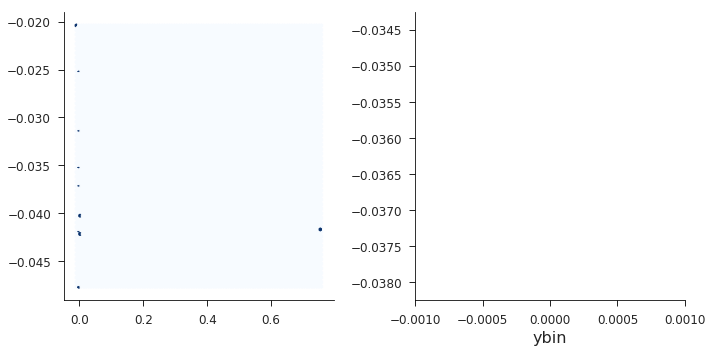

In [45]:
eval_model(model, X_valid, y_valid)

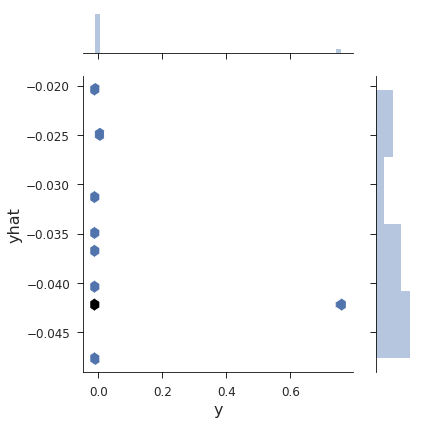

In [46]:
# evaluate model
yhat_valid = model.predict(X_valid)
res_valid = pd.DataFrame({'y': y_valid[:,0], 'yhat': yhat_valid[:,0]}).astype(np.float)
res_valid['err'] = res_valid['yhat'] - res_valid['y']
res_valid1 = res_valid.query('y > -2 and y < 2 and yhat > -2 and yhat < 2')
sns.jointplot('y', 'yhat', data=res_valid1, kind='hex');

In [ ]:
# evaluate fit
yhat_train = model.predict(X_train)
res_train = pd.DataFrame({'y': y_train[:,0], 'yhat': yhat_train[:,0]}).astype(np.float)
res_train['err'] = res_train['yhat'] - res_train['y']
res_train1 = res_train.query('y > -2 and y < 2 and yhat > -2 and yhat < 2')
sns.jointplot('y', 'yhat', data=res_train1, kind='hex');

In [ ]:
nbins = 10
bins = np.linspace(-2, 2, nbins)
res_valid['ybin'] = np.digitize(res_valid['y'], bins)
res_valid['ybin'] = np.minimum(nbins-1, res_valid['ybin'])
bmean = res_valid.groupby('ybin')['yhat'].mean()
bmean.index = bins
bmean.plot();

In [ ]:
nbins = 10
bins = np.linspace(-2, 2, nbins)
res_train['ybin'] = np.digitize(res_train['y'], bins)
res_train['ybin'] = np.minimum(nbins-1, res_train['ybin'])
bmean = res_train.groupby('ybin')['yhat'].mean()
bmean.index = bins
bmean.plot();

### Classical

In [15]:
model_mean = keras.Sequential([
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1)
])
model_mean.compile(loss='mean_squared_error', optimizer='adam')
history = model_mean.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])

Instructions for updating:
Use tf.cast instead.
Train on 40 samples, validate on 10 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
40/40 [==============================] - 0s 4ms/sample - loss: 0.3173 - val_loss: 0.0575
Epoch 2/10
40/40 [==============================] - 0s 266us/sample - loss: 0.3173 - val_loss: 0.0575
Epoch 3/10
40/40 [==============================] - 0s 250us/sample - loss: 0.3173 - val_loss: 0.0576
Epoch 4/10
40/40 [==============================] - 0s 216us/sample - loss: 0.3172 - val_loss: 0.0577
Epoch 5/10
40/40 [==============================] - 0s 252us/sample - loss: 0.3172 - val_loss: 0.0578
Epoch 6/10
40/40 [==============================] - 0s 218us/sample - loss: 0.3171 - val_loss: 0.0579
Epoch 7/10
40/40 [==============================] - 0s 276us/sample - loss: 0.3171 - val_loss: 0.0580
Epoch 8/10
40/40 [==============================] - 0s 270us/sample - loss: 0.3171 - val_loss: 0.0581
Epoch 9/10
40/40 [============================

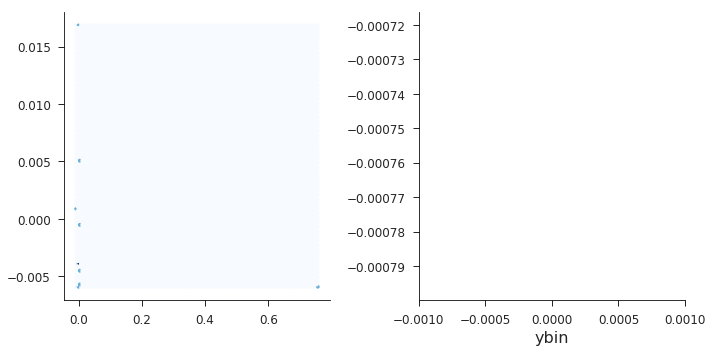

In [42]:
eval_model(model_mean, X_valid, y_valid)

In [33]:
x = model_mean.layers[1]
x.get_weights()

[array([[1.2474184]], dtype=float32), array([-0.0062711], dtype=float32)]